In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import skfuzzy as fuzz
import skfuzzy.control as ctrl

import random
from deap import base, creator, tools, algorithms

import os
import time
import csv


In [2]:
os.makedirs("results/mf_plots", exist_ok=True)
os.makedirs("results/logs", exist_ok=True)
os.makedirs("results/fitness_curves", exist_ok=True)
os.makedirs("results/rule_visuals", exist_ok=True)


In [3]:
# Load Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# We'll use petal length (2) and width (3)
X_selected = X_scaled[:, [2, 3]]

In [4]:
NUM_GENES = 18  # 3 MFs x 3 points x 2 features

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NUM_GENES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [5]:
def decode_and_evaluate(individual):
    # Decode the 18 gene chromosome into MF points
    pl_mfs = np.array(individual[:9]).reshape(3, 3)
    pw_mfs = np.array(individual[9:]).reshape(3, 3)

    # Sort each MF to ensure increasing order for triangle points
    pl_mfs = np.sort(pl_mfs, axis=1)
    pw_mfs = np.sort(pw_mfs, axis=1)

    # Define fuzzy variables
    ple = ctrl.Antecedent(np.linspace(0, 1, 100), "petal_length")
    pwi = ctrl.Antecedent(np.linspace(0, 1, 100), "petal_width")
    cls = ctrl.Consequent(np.linspace(0, 2, 100), "species")

    # Assign decoded MFs
    ple["short"]  = fuzz.trimf(ple.universe, pl_mfs[0])
    ple["medium"] = fuzz.trimf(ple.universe, pl_mfs[1])
    ple["long"]   = fuzz.trimf(ple.universe, pl_mfs[2])

    pwi["narrow"] = fuzz.trimf(pwi.universe, pw_mfs[0])
    pwi["medium"] = fuzz.trimf(pwi.universe, pw_mfs[1])
    pwi["wide"]   = fuzz.trimf(pwi.universe, pw_mfs[2])

    # Output MFs (fixed)
    cls["setosa"]     = fuzz.trimf(cls.universe, [0.0, 0.0, 1.0])
    cls["versicolor"] = fuzz.trimf(cls.universe, [0.5, 1.0, 1.5])
    cls["virginica"]  = fuzz.trimf(cls.universe, [1.0, 2.0, 2.0])

    # Define rules
    rule1 = ctrl.Rule(ple["short"] & pwi["narrow"], cls["setosa"])
    rule2 = ctrl.Rule(ple["medium"] & pwi["medium"], cls["versicolor"])
    rule3 = ctrl.Rule(ple["long"] & pwi["wide"], cls["virginica"])

    system = ctrl.ControlSystem([rule1, rule2, rule3])
    sim = ctrl.ControlSystemSimulation(system)

    # Predict for each row
    preds = []
    for pl, pw in X_selected:
        try:
            sim.input["petal_length"] = pl
            sim.input["petal_width"] = pw
            sim.compute()
            output = sim.output["species"]
            predicted_class = int(round(output))
            preds.append(predicted_class)
        except:
            preds.append(0)  # fallback if FIS fails

    # Return accuracy
    acc = accuracy_score(y, preds)
    return (acc,)


In [6]:
toolbox.register("evaluate", decode_and_evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


In [7]:
# Parameters
POP_SIZE = 30
GENS = 20

pop = toolbox.population(n=POP_SIZE)

# Stats to track fitness
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

logbook = tools.Logbook()
logbook.header = ["gen", "avg", "min", "max"]

# Run GA
start_time = time.time()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                   ngen=GENS, stats=stats, verbose=True)
end_time = time.time()

best_ind = tools.selBest(pop, 1)[0]
print(f"\nBest Accuracy: {best_ind.fitness.values[0]:.4f}")


gen	nevals	avg     	max     	min 
0  	30    	0.556222	0.906667	0.14
1  	19    	0.627778	0.913333	0.1 
2  	15    	0.739111	0.893333	0.553333
3  	19    	0.769556	0.933333	0.593333
4  	20    	0.769111	0.953333	0.473333
5  	21    	0.803111	0.953333	0.4     
6  	16    	0.865556	0.953333	0.52    
7  	13    	0.914444	0.953333	0.66    
8  	13    	0.946444	0.96    	0.893333
9  	23    	0.939778	0.96    	0.72    
10 	22    	0.953111	0.96    	0.893333
11 	23    	0.952667	0.96    	0.92    
12 	15    	0.958889	0.96    	0.953333
13 	19    	0.956444	0.96    	0.86    
14 	22    	0.958667	0.96    	0.946667
15 	12    	0.955111	0.96    	0.893333
16 	19    	0.953778	0.96    	0.893333
17 	21    	0.956222	0.96    	0.893333
18 	22    	0.952   	0.96    	0.86    
19 	15    	0.949333	0.96    	0.76    
20 	18    	0.947111	0.96    	0.773333

Best Accuracy: 0.9600


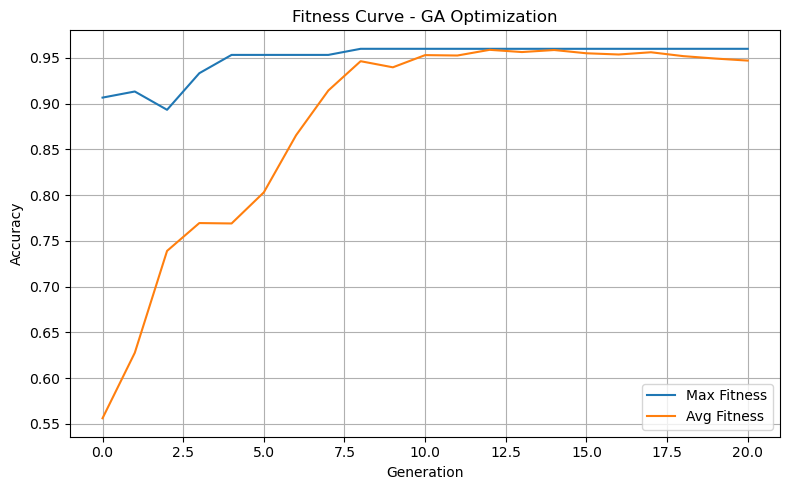

In [8]:
# Extract fitness values
gen_vals = list(range(GENS + 1))
fit_max = [record["max"] for record in logbook]
fit_avg = [record["avg"] for record in logbook]

# Plot fitness curve
plt.figure(figsize=(8, 5))
plt.plot(gen_vals, fit_max, label="Max Fitness")
plt.plot(gen_vals, fit_avg, label="Avg Fitness")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.title("Fitness Curve - GA Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/fitness_curves/ga_fitness_curve.png")
plt.show()


In [9]:
# Decode MF widths from best individual
pl_mfs_best = np.array(best_ind[:9]).reshape(3, 3)
pw_mfs_best = np.array(best_ind[9:]).reshape(3, 3)
pl_mfs_best = np.sort(pl_mfs_best, axis=1)
pw_mfs_best = np.sort(pw_mfs_best, axis=1)

mf_widths = []
for mf in pl_mfs_best.tolist() + pw_mfs_best.tolist():
    width = mf[2] - mf[0]  # base of triangle
    mf_widths.append(width)

avg_mf_width = round(np.mean(mf_widths), 4)

# Log to accuracy file
method = "ga_optimized_fis"
accuracy_val = round(best_ind.fitness.values[0], 4)
num_rules = 3
train_time = round(end_time - start_time, 3)
notes = f"GA optimized fuzzy system in {GENS} generations"

with open("results/accuracy_logs.csv", "a", newline='') as f:
    writer = csv.writer(f)
    writer.writerow([method, accuracy_val, num_rules, avg_mf_width, train_time, notes])


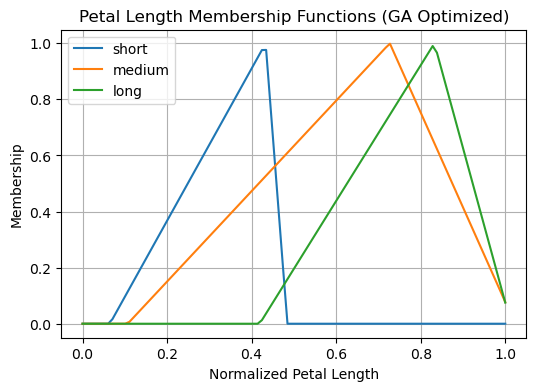

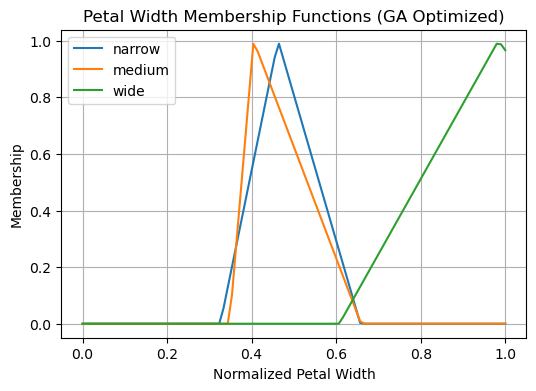

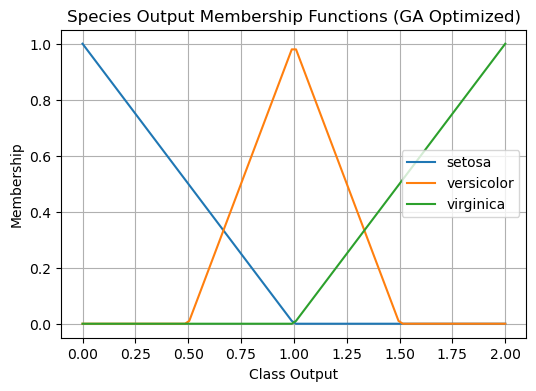

In [10]:
# Extract best MF values
x = np.linspace(0, 1, 100)

# GA-optimized Petal Length MFs
pl_short  = fuzz.trimf(x, pl_mfs_best[0])
pl_medium = fuzz.trimf(x, pl_mfs_best[1])
pl_long   = fuzz.trimf(x, pl_mfs_best[2])

plt.figure(figsize=(6, 4))
plt.plot(x, pl_short, label='short')
plt.plot(x, pl_medium, label='medium')
plt.plot(x, pl_long, label='long')
plt.title("Petal Length Membership Functions (GA Optimized)")
plt.xlabel("Normalized Petal Length")
plt.ylabel("Membership")
plt.legend()
plt.grid(True)
plt.savefig("results/mf_plots/ga_petallength.png")
plt.show()

# GA-optimized Petal Width MFs
pw_narrow = fuzz.trimf(x, pw_mfs_best[0])
pw_medium = fuzz.trimf(x, pw_mfs_best[1])
pw_wide   = fuzz.trimf(x, pw_mfs_best[2])

plt.figure(figsize=(6, 4))
plt.plot(x, pw_narrow, label='narrow')
plt.plot(x, pw_medium, label='medium')
plt.plot(x, pw_wide, label='wide')
plt.title("Petal Width Membership Functions (GA Optimized)")
plt.xlabel("Normalized Petal Width")
plt.ylabel("Membership")
plt.legend()
plt.grid(True)
plt.savefig("results/mf_plots/ga_petalwidth.png")
plt.show()

# Output MFs (fixed)
x_out = np.linspace(0, 2, 100)
plt.figure(figsize=(6, 4))
plt.plot(x_out, fuzz.trimf(x_out, [0.0, 0.0, 1.0]), label='setosa')
plt.plot(x_out, fuzz.trimf(x_out, [0.5, 1.0, 1.5]), label='versicolor')
plt.plot(x_out, fuzz.trimf(x_out, [1.0, 2.0, 2.0]), label='virginica')
plt.title("Species Output Membership Functions (GA Optimized)")
plt.xlabel("Class Output")
plt.ylabel("Membership")
plt.legend()
plt.grid(True)
plt.savefig("results/mf_plots/ga_output_species.png")
plt.show()
